<a href="https://colab.research.google.com/github/Boburshoh-oss/Autonumberdetection/blob/main/02_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
df = pd.read_csv("labels.csv")
df.head()

,filepath,xmin,xmax,ymin,ymax
0,./images/N162.xml,147,336,169,209
1,./images/N220.xml,182,349,238,273
2,./images/N114.xml,15,200,33,126
3,./images/N136.xml,787,910,473,513
4,./images/N241.xml,251,542,308,385


In [ ]:
import xml.etree.ElementTree as xet

In [ ]:
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/images.zip", 'r') as zipObj:
  zipObj.extractall()

In [ ]:
filename = df['filepath'][0]
filename

'./images/N162.xml'

In [ ]:
def get_filename(filename):
  filename_image = xet.parse(filename).getroot().find('filename').text
  filepath_image = os.path.join('./images', filename_image)
  return filepath_image

In [ ]:
get_filename(filename)

'./images/N162.jpeg'

In [ ]:
image_path = list(df['filepath'].apply(get_filename))
image_path

['./images/N162.jpeg',
 './images/N220.jpeg',
 './images/N114.jpeg',
 './images/N136.jpeg',
 './images/N241.jpeg',
 './images/N231.jpeg',
 './images/N99.jpeg',
 './images/N246.jpeg',
 './images/N57.jpeg',
 './images/N18.jpeg',
 './images/N90.jpeg',
 './images/N145.jpeg',
 './images/N191.jpeg',
 './images/N152.jpeg',
 './images/N21.jpeg',
 './images/N61.jpeg',
 './images/N38.jpeg',
 './images/N206.jpeg',
 './images/N96.jpeg',
 './images/N130.jpeg',
 './images/N245.jpeg',
 './images/N210.jpeg',
 './images/N225.jpeg',
 './images/N172.jpeg',
 './images/N197.jpeg',
 './images/N142.jpeg',
 './images/N184.jpeg',
 './images/N216.jpeg',
 './images/N67.jpeg',
 './images/N91.jpeg',
 './images/N201.jpeg',
 './images/N4.jpeg',
 './images/N230.jpeg',
 './images/N31.jpeg',
 './images/N86.jpeg',
 './images/N8.jpeg',
 './images/N17.jpeg',
 './images/N93.jpeg',
 './images/N192.jpeg',
 './images/N120.jpeg',
 './images/N44.jpeg',
 './images/N173.jpeg',
 './images/N208.jpeg',
 './images/N15.jpeg',
 './imag

In [ ]:
#### verify image and output

In [ ]:
file_path = image_path[0]
file_path

'./images/N162.jpeg'

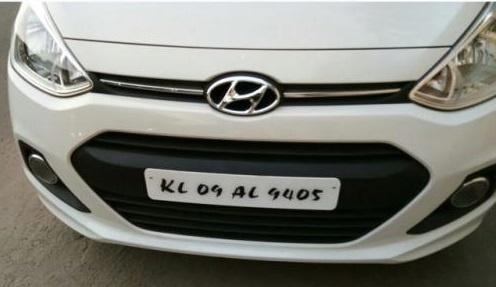

In [ ]:
img = cv2.imread(file_path)

# cv2.namedWindow('example', cv2.WINDOW_NORMAL)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

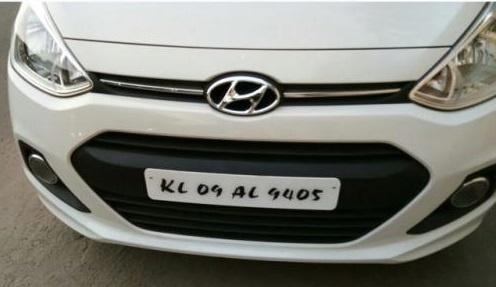

In [ ]:
cv2.rectangle(img,(1093,645),(1396,727),(0,255,0),3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
labels = df.iloc[:,1:].values


In [ ]:
data = []
output = []
for ind in range(len(image_path)):
  image = image_path[ind]
  img_arr = cv2.imread(image)
  h,w,d = img_arr.shape
  #prepprocesing
  load_image = load_img(image, target_size=(224,224))
  load_image_arr = img_to_array(load_image)
  norm_load_image_arr = load_image_arr/255.0 #normalization
  #normalization to labels
  xmin,xmax,ymin,ymax = labels[ind]
  nxmin,nxmax = xmin/w,xmax/w
  nymin,nymax = ymin/h,xmax/h
  label_norm = (nxmin,nxmax,nymin,nymax) #normalization output
  data.append(norm_load_image_arr)
  output.append(label_norm)

In [ ]:
X = np.array(data, dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [ ]:
X.shape, y.shape

((225, 224, 224, 3), (225, 4))

In [ ]:
x_train, x_test, ytrain, y_test = train_test_split(X,y, train_size=0.8, random_state=0)
x_train.shape, x_test.shape

((180, 224, 224, 3), (45, 224, 224, 3))

In [ ]:
#Deep learning model

In [ ]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3, InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow as tf

In [ ]:
inception_resnet = InceptionResNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))
inception_resnet.trainable = False

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation='relu')(headmodel)
headmodel = Dense(250,activation='relu')(headmodel)
headmodel = Dense(4, activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input, outputs=headmodel)

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
#complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_1[0][0]']               
 alization)                     )                                                             

In [ ]:
#model training

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
tfb = TensorBoard('object_detection')

In [ ]:
history = model.fit(x=x_train,y=ytrain, batch_size=10,epochs=100, validation_data=(x_test, y_test),callbacks=[tfb])

Epoch 1/100
18/18 [==============================] - 79s 4s/step - loss: 0.1103 - val_loss: 0.0949
Epoch 2/100
18/18 [==============================] - 50s 3s/step - loss: 0.0995 - val_loss: 0.1021
Epoch 3/100
18/18 [==============================] - 50s 3s/step - loss: 0.0931 - val_loss: 0.1059
Epoch 4/100
18/18 [==============================] - 51s 3s/step - loss: 0.1028 - val_loss: 0.1018
Epoch 5/100
18/18 [==============================] - 50s 3s/step - loss: 0.0910 - val_loss: 0.0887
Epoch 6/100
18/18 [==============================] - 54s 3s/step - loss: 0.0844 - val_loss: 0.0927
Epoch 7/100
18/18 [==============================] - 52s 3s/step - loss: 0.0833 - val_loss: 0.0853
Epoch 8/100
18/18 [==============================] - 51s 3s/step - loss: 0.0807 - val_loss: 0.1003
Epoch 9/100
18/18 [==============================] - 51s 3s/step - loss: 0.0836 - val_loss: 0.0989
Epoch 10/100
18/18 [==============================] - 54s 3s/step - loss: 0.0834 - val_loss: 0.0831
Epoch 11/

In [ ]:
history = model.fit(x=x_train,y=ytrain, batch_size=10,epochs=200, validation_data=(x_test, y_test),callbacks=[tfb],initial_epoch=100)

Epoch 101/200
18/18 [==============================] - 52s 3s/step - loss: 0.0170 - val_loss: 0.0235
Epoch 102/200
18/18 [==============================] - 51s 3s/step - loss: 0.0173 - val_loss: 0.0246
Epoch 103/200
18/18 [==============================] - 50s 3s/step - loss: 0.0179 - val_loss: 0.0275
Epoch 104/200
18/18 [==============================] - 51s 3s/step - loss: 0.0182 - val_loss: 0.0268
Epoch 105/200
18/18 [==============================] - 62s 3s/step - loss: 0.0173 - val_loss: 0.0244
Epoch 106/200
18/18 [==============================] - 50s 3s/step - loss: 0.0166 - val_loss: 0.0246
Epoch 107/200
18/18 [==============================] - 50s 3s/step - loss: 0.0166 - val_loss: 0.0236
Epoch 108/200
18/18 [==============================] - 50s 3s/step - loss: 0.0164 - val_loss: 0.0243
Epoch 109/200
18/18 [==============================] - 61s 3s/step - loss: 0.0163 - val_loss: 0.0241
Epoch 110/200
18/18 [==============================] - 50s 3s/step - loss: 0.0163 - val_los

In [ ]:
model.save("object_detection.h5")